In [28]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from pathlib import Path
import geobr 
from pysus import SINAN 
import os
def preparar_dataset_dengue_clima(
    path_inmet_zip: str, 
    path_ibge_csv: str,
    path_dengue_parquet: str = None, 
    ano_referencia: int = 2021
):
    print(f"\n>>> Processando Ano {ano_referencia} com Tratamento de Gaps <<<")
    
    # --- 1. DENGUE ---
    print("1. Carregando dados de Dengue...")
    df_dengue = None
    
    if path_dengue_parquet:
        try:
            df_dengue = pd.read_parquet(path_dengue_parquet)
        except FileNotFoundError:
            pass
            
    if df_dengue is None:
        try:
            p_home = Path.home() / "pysus" / f"DENGBR{str(ano_referencia)[-2:]}.parquet"
            if p_home.exists():
                df_dengue = pd.read_parquet(p_home)
        except:
            pass
            
    if df_dengue is None:
        print("   Arquivo local não encontrado. Baixando via PySUS...")
        try:
            sinan = SINAN().load()
            files = sinan.get_files(dis_code=["DENG"], year=ano_referencia)
            df_dengue = sinan.download(files) 
        except Exception as e:
            print(f"   Erro fatal ao baixar Dengue: {e}")
            return None

    # Filtros
    df_dengue = df_dengue[df_dengue["CLASSI_FIN"].astype(str).str.strip() != "5"]
    df_dengue_agg = df_dengue.groupby(["DT_NOTIFIC", "ID_MUNICIP"]).size().reset_index(name="casos_dengue")
    df_dengue_agg["ID_MUNICIP"] = df_dengue_agg["ID_MUNICIP"].astype(int)
    
    # --- 2. INMET ---
    print("2. Processando dados do INMET...")
    try:
        from reader_inmet import read_zipfile
        df_inmet = read_zipfile(path_inmet_zip)
    except ImportError:
        df_inmet = pd.read_csv(path_inmet_zip) 
        
    df_inmet['data_hora'] = pd.to_datetime(df_inmet['data_hora'])
    df_inmet['data_date'] = df_inmet['data_hora'].dt.date # Usar objeto date para reindexar
    
    # 2.1 Agregação Diária Inicial
    aggs = {
        'precipitacao': 'sum',
        'temperatura_maxima': 'max',
        'temperatura_minima': 'min',
        'temperatura_ar': 'mean',
        'umidade_relativa': 'mean',
        'vento_velocidade': 'mean',
        'latitude': 'first',
        'longitude': 'first'
    }
    cols_existentes = [c for c in aggs.keys() if c in df_inmet.columns]
    aggs_finais = {k: v for k, v in aggs.items() if k in cols_existentes}

    # Agrupa por Estação e Data
    df_inmet_diario = df_inmet.groupby(['codigo_wmo', 'data_date']).agg(aggs_finais).reset_index()

  # --- 2.2 ETAPA DE INTERPOLAÇÃO ---
    print("   Aplicando preenchimento de falhas nas estações (Gap Filling)...")
    
    # Cria um intervalo de datas completo para o ano
    all_dates = pd.date_range(start=f'{ano_referencia}-01-01', end=f'{ano_referencia}-12-31', freq='D').date
    
    lista_dfs_curados = []
    
    # Processa cada estação individualmente
    for estacao, dados in df_inmet_diario.groupby('codigo_wmo'):
        # Reindexa para garantir que todos os dias existam (cria NaNs nos dias faltantes)
        dados = dados.set_index('data_date').reindex(all_dates)
        
        # Preenche metadados (lat/lon/codigo) que ficaram NaN na reindexação
        dados['codigo_wmo'] = estacao
        # Lat/Lon são constantes da estação, aqui pode usar bfill/ffill sem risco de vazamento temporal grave
        dados['latitude'] = dados['latitude'].ffill().bfill()
        dados['longitude'] = dados['longitude'].ffill().bfill()
        
        cols_numericas = [c for c in cols_existentes if c not in ['latitude', 'longitude']]
        
   
        dados[cols_numericas] = dados[cols_numericas].ffill(limit=5) 
        # ffill = Forward Fill (Preenche com o valor anterior). 
        # Se quiser ser muito cauteloso, pode adicionar um .fillna(0) para chuva se o ffill falhar no primeiro dia.
        
        dados.index.name = 'data_date'
        lista_dfs_curados.append(dados.reset_index())
    
    # Reconstrói o DF tratado
    df_inmet_full = pd.concat(lista_dfs_curados)
    df_inmet_full['DT_NOTIFIC'] = pd.to_datetime(df_inmet_full['data_date']).dt.strftime('%Y%m%d')

    # --- 3. GEO ---
    print("3. Realizando Join Espacial...")
    try:
        df_geo = geobr.read_municipal_seat(year=2010)
        df_geo['id_municip_6'] = (df_geo['code_muni'] // 10).astype(int)
        
        geo_col = 'geometry' if 'geometry' in df_geo.columns else 'geom'
        df_geo['lat_mun'] = df_geo[geo_col].apply(lambda x: x.y)
        df_geo['lon_mun'] = df_geo[geo_col].apply(lambda x: x.x)
    except Exception as e:
        print(f"Erro no geobr: {e}")
        return None

    # KDTree - Usando apenas estações que sobraram no df_inmet_full (algumas podem ter sumido se vazias)
    estacoes_validas = df_inmet_full[['codigo_wmo', 'latitude', 'longitude']].drop_duplicates().dropna()
    municipios_validos = df_geo[['id_municip_6', 'name_muni', 'lat_mun', 'lon_mun']].drop_duplicates().dropna(subset=['lat_mun', 'lon_mun'])
    
    tree = cKDTree(estacoes_validas[['latitude', 'longitude']].values)
    distancias, indices = tree.query(municipios_validos[['lat_mun', 'lon_mun']].values, k=1)
    
    municipios_validos['estacao_proxima'] = estacoes_validas.iloc[indices]['codigo_wmo'].values
    mapa_estacoes = municipios_validos[['id_municip_6', 'name_muni', 'estacao_proxima']]

    # --- 4. MERGE ---
    print("4. Unificando datasets...")
    
    df_final = pd.merge(df_dengue_agg, mapa_estacoes, left_on='ID_MUNICIP', right_on='id_municip_6', how='left')
    
    # Merge com o INMET curado
    df_final = pd.merge(
        df_final, 
        df_inmet_full, 
        left_on=['estacao_proxima', 'DT_NOTIFIC'], 
        right_on=['codigo_wmo', 'DT_NOTIFIC'], 
        how='left'
    )
    
    if 'id_municip_6' in df_final.columns:
        df_final.drop(columns=['id_municip_6'], inplace=True)
    if 'data_date' in df_final.columns:
        df_final.drop(columns=['data_date'], inplace=True)
        
    print(f"   Shape final: {df_final.shape}")
    print(f"   Linhas com NaN na temp média: {df_final['temperatura_ar'].isna().sum()}")
    df_final = df_final.sort_values('DT_NOTIFIC')
    return df_final

In [29]:
years_to_process = [2020, 2021, 2022, 2023]
ibge_path = "data/RELATORIO_DTB_BRASIL_2024_MUNICIPIOS.csv"
dfs_result = []

for year in years_to_process:
    inmet_path = f"data/{year}.zip"
    
    # Verifica se arquivos existem antes de chamar (para evitar logs de erro desnecessários)
    if os.path.exists(inmet_path):
        try:
            df_year = preparar_dataset_dengue_clima(
                path_inmet_zip=inmet_path,
                path_ibge_csv=ibge_path,
                ano_referencia=year
            )
            if df_year is not None and not df_year.empty:
                dfs_result.append(df_year)
                print(f"   > Sucesso: {len(df_year)} registros para {year}")
            else:
                print(f"   > Aviso: Nenhum dado gerado para {year}")
        except Exception as e:
            print(f"   > Falha ao processar {year}: {e}")
    else:
        print(f"   > Arquivo INMET não encontrado para {year} ({inmet_path}), pulando.")

# Concatenação e Salvamento
if dfs_result:
    df_merged = pd.concat(dfs_result, ignore_index=True)
    df_merged.sort_values("DT_NOTIFIC", inplace=True)
    
    output_filename = "dengue_clima_2020_2024.csv"
    df_merged.to_csv(output_filename, index=False)
    
    print("\n" + "="*30)
    print(f"CONSOLIDADO FINAL (2020-2024)")
    print(f"Arquivo salvo: {output_filename}")
    print(f"Total de registros: {len(df_merged)}")
    print("Colunas:", list(df_merged.columns))
    print(df_merged.head())
else:
    print("Nenhum dado foi processado com sucesso.")


>>> Processando Ano 2020 com Tratamento de Gaps <<<
1. Carregando dados de Dengue...
2. Processando dados do INMET...


100%|██████████| 589/589 [01:10<00:00,  8.37it/s]


   Aplicando preenchimento de falhas nas estações (Gap Filling)...
3. Realizando Join Espacial...
4. Unificando datasets...
   Shape final: (173242, 14)
   Linhas com NaN na temp média: 14926
   > Sucesso: 173242 registros para 2020

>>> Processando Ano 2021 com Tratamento de Gaps <<<
1. Carregando dados de Dengue...
2. Processando dados do INMET...


100%|██████████| 588/588 [00:41<00:00, 14.24it/s]


   Aplicando preenchimento de falhas nas estações (Gap Filling)...
3. Realizando Join Espacial...
4. Unificando datasets...
   Shape final: (112129, 14)
   Linhas com NaN na temp média: 24864
   > Sucesso: 112129 registros para 2021

>>> Processando Ano 2022 com Tratamento de Gaps <<<
1. Carregando dados de Dengue...
2. Processando dados do INMET...


100%|██████████| 567/567 [01:01<00:00,  9.20it/s]


   Aplicando preenchimento de falhas nas estações (Gap Filling)...
3. Realizando Join Espacial...
4. Unificando datasets...
   Shape final: (214659, 14)
   Linhas com NaN na temp média: 41858
   > Sucesso: 214659 registros para 2022

>>> Processando Ano 2023 com Tratamento de Gaps <<<
1. Carregando dados de Dengue...
2. Processando dados do INMET...


100%|██████████| 567/567 [01:12<00:00,  7.80it/s]


   Aplicando preenchimento de falhas nas estações (Gap Filling)...
3. Realizando Join Espacial...
4. Unificando datasets...
   Shape final: (213841, 14)
   Linhas com NaN na temp média: 17734
   > Sucesso: 213841 registros para 2023

CONSOLIDADO FINAL (2020-2024)
Arquivo salvo: dengue_clima_2020_2024.csv
Total de registros: 713871
Colunas: ['DT_NOTIFIC', 'ID_MUNICIP', 'casos_dengue', 'name_muni', 'estacao_proxima', 'codigo_wmo', 'precipitacao', 'temperatura_maxima', 'temperatura_minima', 'temperatura_ar', 'umidade_relativa', 'vento_velocidade', 'latitude', 'longitude']
    DT_NOTIFIC  ID_MUNICIP  casos_dengue                 name_muni  \
0     20191229      110014             1  Nova Brasilândia D'oeste   
124   20191229      110037             1   Alto Alegre Dos Parecis   
125   20191229      120001             1                Acrelândia   
126   20191229      120020            10           Cruzeiro Do Sul   
127   20191229      120070             2                    Xapuri   

   

In [30]:
df_sp = df_merged[df_merged['name_muni'] == 'São Paulo']
df_sp

,DT_NOTIFIC,ID_MUNICIP,casos_dengue,name_muni,estacao_proxima,codigo_wmo,precipitacao,temperatura_maxima,temperatura_minima,temperatura_ar,umidade_relativa,vento_velocidade,latitude,longitude
38,20191229,355030,3,São Paulo,A701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,20191230,355030,9,São Paulo,A701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
591,20191231,355030,2,São Paulo,A701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
813,20200101,355030,1,São Paulo,A701,A701,16.0,33.3,19.2,25.491667,60.791667,1.929167,-23.496294,-46.620088
1043,20200102,355030,9,São Paulo,A701,A701,23.6,28.8,20.0,22.625000,76.583333,1.291667,-23.496294,-46.620088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711253,20231226,355030,93,São Paulo,A701,A701,1.0,29.3,20.6,25.283333,63.208333,1.862500,-23.496389,-46.620000
711798,20231227,355030,83,São Paulo,A701,A701,0.0,27.2,18.1,21.495652,60.260870,2.486957,-23.496389,-46.620000
712378,20231228,355030,66,São Paulo,A701,A701,0.0,32.3,17.3,22.962500,58.333333,2.187500,-23.496389,-46.620000
712971,20231229,355030,58,São Paulo,A701,A701,0.0,34.7,19.6,26.833333,51.916667,1.970833,-23.496389,-46.620000


In [31]:
# 1. Converter data para datetime (caso ainda não esteja)
df_sp['DT_NOTIFIC'] = pd.to_datetime(df_sp['DT_NOTIFIC'], format='%Y%m%d')
df_sp = df_sp.sort_values('DT_NOTIFIC')

# 2. Tratamento de Gaps (Evitar Data Leak)
# Use apenas ffill para não olhar para o futuro
cols_interp = ['temperatura_ar', 'umidade_relativa', 'temperatura_maxima', 'temperatura_minima', 'vento_velocidade']
for c in cols_interp:
    if c in df_sp.columns:
        df_sp[c] = df_sp[c].ffill() # Apenas propaga o valor anterior

# Preenche chuva e restantes com 0
df_sp = df_sp.fillna(0)

# 3. Agregação Semanal
# Definimos o dicionário de agregação: Soma para casos/chuva, Média para outros
agg_dict = {
    'casos_dengue': 'sum',
    'precipitacao': 'sum',
    'temperatura_maxima': 'max',
    'temperatura_minima': 'min',
    'temperatura_ar': 'mean',
    'umidade_relativa': 'mean',
    'vento_velocidade': 'mean'
}

# Filtra apenas colunas que existem no df
agg_dict = {k: v for k, v in agg_dict.items() if k in df_sp.columns}

# Resample 'W' (Weekly)
df_semanal = df_sp.set_index('DT_NOTIFIC').resample('W').agg(agg_dict).reset_index()

print(f"Total de Semanas: {len(df_semanal)}")
print(df_semanal.head())

Total de Semanas: 210
  DT_NOTIFIC  casos_dengue  precipitacao  temperatura_maxima  \
0 2019-12-29             3           0.0                 0.0   
1 2020-01-05            41          62.6                33.3   
2 2020-01-12            87         105.2                31.6   
3 2020-01-19            89          87.8                31.9   
4 2020-01-26           109           8.2                30.9   

   temperatura_minima  temperatura_ar  umidade_relativa  vento_velocidade  
0                 0.0        0.000000          0.000000          0.000000  
1                 0.0       15.812500         53.375000          1.133929  
2                18.0       24.858333         70.017857          2.004167  
3                17.1       22.186905         74.035714          2.182738  
4                16.0       20.865476         71.011905          2.006548  


/tmp/ipykernel_5380/2044883811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp['DT_NOTIFIC'] = pd.to_datetime(df_sp['DT_NOTIFIC'], format='%Y%m%d')


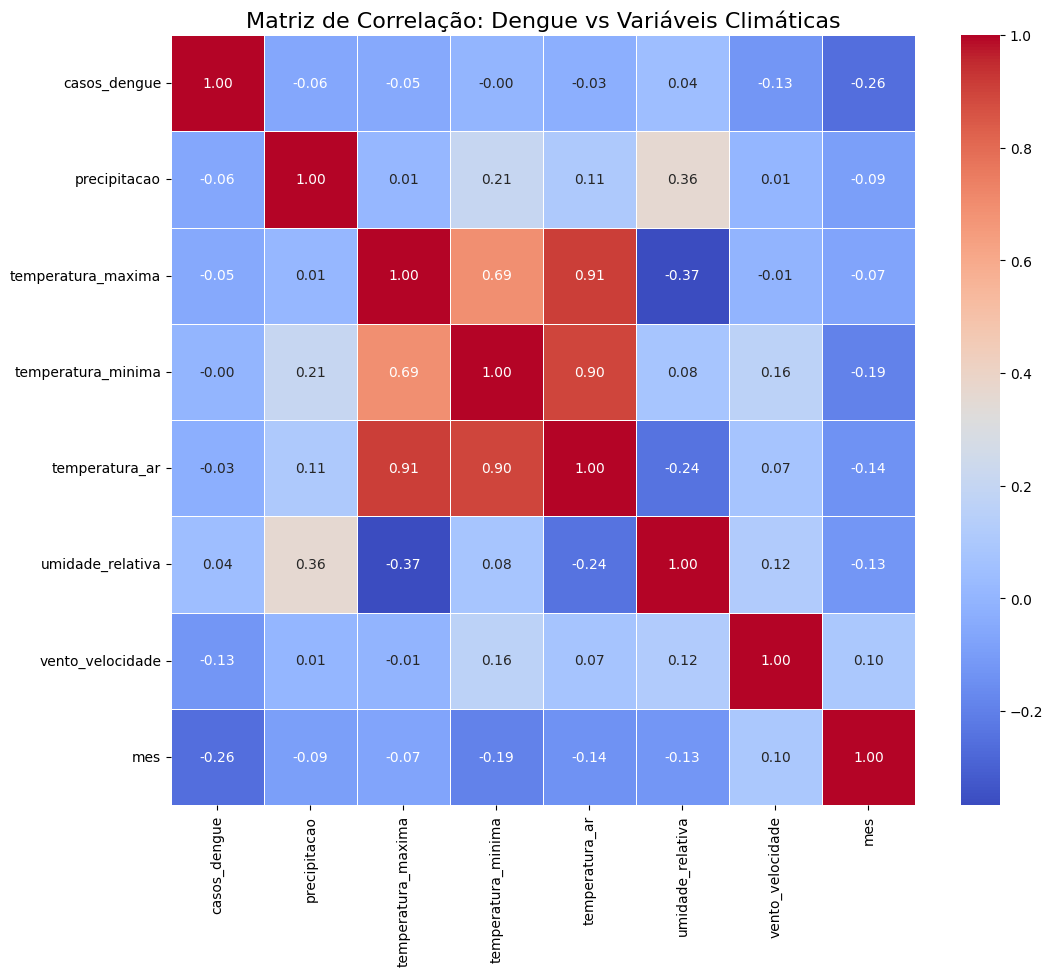

Colunas prontas para ML: ['casos_dengue', 'precipitacao', 'temperatura_maxima', 'temperatura_minima', 'temperatura_ar', 'umidade_relativa', 'vento_velocidade', 'mes']


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analisar_correlacao_ml(df):
    # Seleção de Colunas
    cols_ml = [
        'DT_NOTIFIC',
        'casos_dengue', 
        'precipitacao', 
        'temperatura_maxima', 
        'temperatura_minima', 
        'temperatura_ar', 
        'umidade_relativa', 
        'vento_velocidade'
    ]
    
    df_ml = df[cols_ml].copy()
    
    # 2. Engenharia de Features
    df_ml['DT_NOTIFIC'] = pd.to_datetime(df_ml['DT_NOTIFIC'])
    df_ml['mes'] = df_ml['DT_NOTIFIC'].dt.month
    
    df_ml = df_ml.drop(columns=['DT_NOTIFIC'])
    
    corr_matrix = df_ml.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix, 
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=0.5
    )
    plt.title("Matriz de Correlação: Dengue vs Variáveis Climáticas", fontsize=16)
    plt.show()
    
    return df_ml

df_para_modelo = analisar_correlacao_ml(df_sp)

print("Colunas prontas para ML:", df_para_modelo.columns.tolist())

In [33]:
def time_series_split(X, y, test_size=0.2):
    """
    Divide conjuntos de dados em treino e teste respeitando a ordem temporal (sem embaralhar).
    Funciona tanto para Pandas (DataFrame/Series) quanto para Numpy arrays.
    
    Parâmetros:
        X: Features (Dados de entrada)
        y: Target (Dados alvo)
        test_size: Porcentagem dos dados para teste (ex: 0.2 para 20%)
        
    Retorna:
        X_train, X_test, y_train, y_test
    """
    # Calcula o índice de corte
    split_index = int(len(X) * (1 - test_size))
    
    # Realiza o slice dependendo do tipo de dado (Pandas ou Numpy)
    if hasattr(X, 'iloc'): # Se for Pandas DataFrame/Series
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    else: # Se for Numpy Array ou Lista
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]
        
    return X_train, X_test, y_train, y_test

>>> Treinando XGBoost (Semanal)...
MAE Semanal (XGBoost) no Teste: 141.74


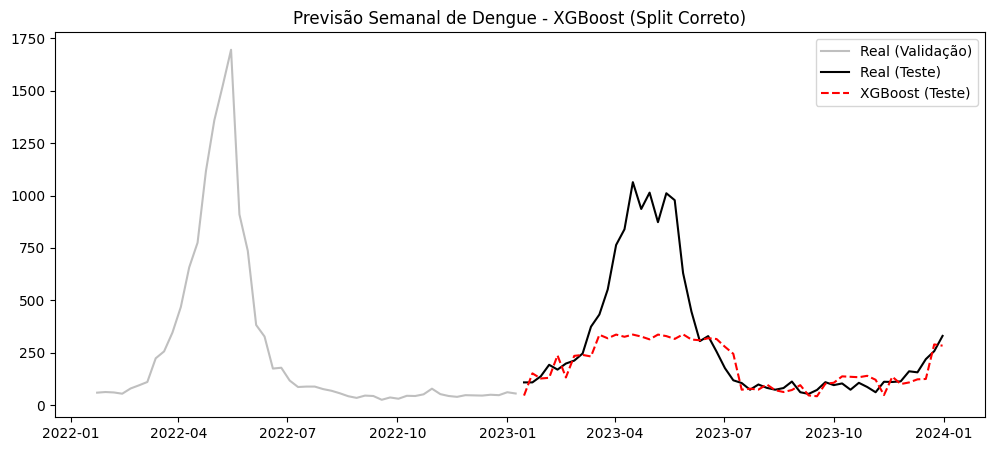

In [34]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def treinar_xgboost_semanal(df):
    print(">>> Treinando XGBoost (Semanal)...")
    df = df.sort_values('DT_NOTIFIC').copy()
    
    # Feature Engineering (Janelas em SEMANAS)
    # Médias móveis de 4 e 8 semanas (1 e 2 meses aprox.)
    for col in ['precipitacao', 'temperatura_ar', 'umidade_relativa']:
        if col in df.columns:
            df[f'{col}_media_4sem'] = df[col].rolling(4).mean()
            df[f'{col}_media_8sem'] = df[col].rolling(8).mean()

    # Lags (Atrasos) de Casos: 1, 2, 3 e 4 semanas atrás
    for i in [1, 2, 3, 4]:
        df[f'casos_lag_{i}sem'] = df['casos_dengue'].shift(i)
        
    # Sazonalidade
    df['semana_do_ano'] = df['DT_NOTIFIC'].dt.isocalendar().week.astype(int)
    df['mes'] = df['DT_NOTIFIC'].dt.month

    df_model = df.dropna().copy()
    
    # Seleção de Features
    features = [c for c in df_model.columns if c not in ['DT_NOTIFIC', 'casos_dengue']]
    
    # Split Temporal em 3 partes (Treino, Validação, Teste)
    # Vamos usar: 70% Treino | 15% Validação | 15% Teste
    n = len(df_model)
    split_val = int(n * 0.50)
    split_test = int(n * 0.75)

    X = df_model[features]
    y = df_model['casos_dengue']

    # 1. Treino (0% a 70%)
    X_train = X.iloc[:split_val]
    y_train = y.iloc[:split_val]

    # 2. Validação (70% a 85%)
    X_val = X.iloc[split_val:split_test]
    y_val = y.iloc[split_val:split_test]

    # 3. Teste (85% a 100%) - O modelo NUNCA vê isso durante o treino
    X_test = X.iloc[split_test:]
    y_test = y.iloc[split_test:]

    # Modelo XGBoost
    model = xgb.XGBRegressor(
        objective='count:poisson', 
        n_estimators=1000, 
        learning_rate=0.05,
        max_depth=5,
        early_stopping_rounds=50
    )

    # IMPORTANTE: No eval_set usamos a VALIDAÇÃO, não o teste
    model.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        verbose=False
    )

    # Avaliação final é feita no conjunto de TESTE (que o modelo não conhece)
    preds = np.maximum(model.predict(X_test), 0)
    mae = mean_absolute_error(y_test, preds)
    print(f"MAE Semanal (XGBoost) no Teste: {mae:.2f}")

    # Plot (mostrando Validação e Teste para visualização)
    plt.figure(figsize=(12, 5))
    plt.plot(df_model['DT_NOTIFIC'].iloc[split_val:split_test], y_val, label='Real (Validação)', color='gray', alpha=0.5)
    plt.plot(df_model['DT_NOTIFIC'].iloc[split_test:], y_test, label='Real (Teste)', color='black')
    plt.plot(df_model['DT_NOTIFIC'].iloc[split_test:], preds, label='XGBoost (Teste)', color='red', linestyle='--')
    plt.title("Previsão Semanal de Dengue - XGBoost (Split Correto)")
    plt.legend()
    plt.show()

modelo_xgb = treinar_xgboost_semanal(df_semanal)

>>> Treinando LSTM com Validação (Janela: 8 semanas)...


/home/Nishimura/anaconda3/envs/dengue_ml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
MAE Semanal (LSTM - Teste): 73.04


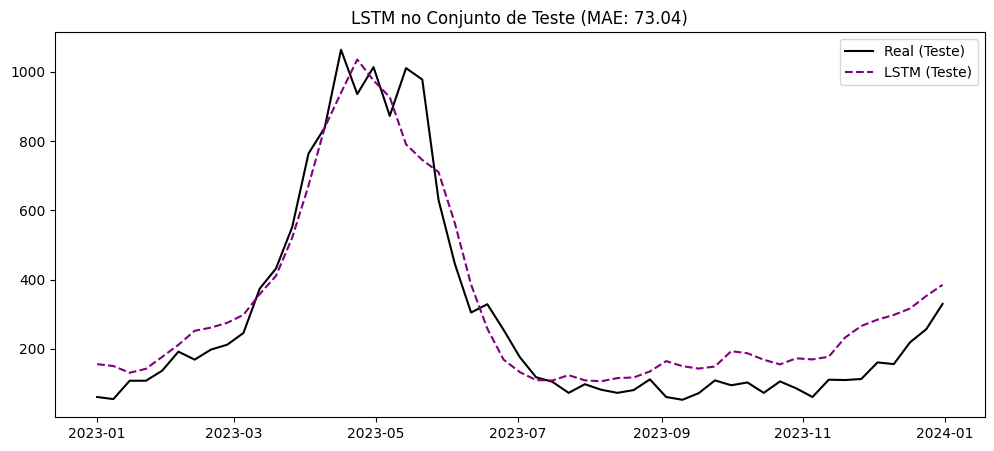

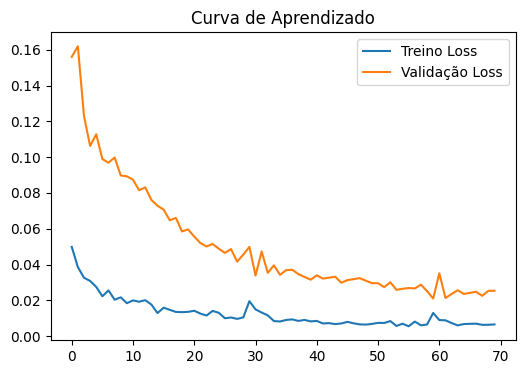

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def criar_sequencias(dados, janela_tempo):
    """
    Transforma os dados em sequências para a LSTM.
    X: Dados de t-janela até t-1
    y: Dado em t (apenas a coluna alvo)
    """
    X, y = [], []
    for i in range(len(dados) - janela_tempo):
        X.append(dados[i:(i + janela_tempo), :])
        y.append(dados[i + janela_tempo, 0])
    return np.array(X), np.array(y)

from tensorflow.keras.callbacks import EarlyStopping

def treinar_lstm_com_validacao(df, janela=8):
    print(f">>> Treinando LSTM com Validação (Janela: {janela} semanas)...")
    
    features = ['casos_dengue', 'precipitacao', 'temperatura_ar', 'umidade_relativa']
    features = [f for f in features if f in df.columns]
    
    data = df[features].values
    n = len(data)
    
    # 1. Definir pontos de corte (70% Treino, 15% Validação, 15% Teste)
    split_val = int(n * 0.50)
    split_test = int(n * 0.75)
    
    # 2. Separar os dados brutos (COM janela de sobreposição para continuidade)
    # A validação precisa das 'janela' semanas anteriores do treino para prever o seu 1º ponto
    train_raw = data[:split_val]
    val_raw = data[split_val - janela : split_test] 
    test_raw = data[split_test - janela :]
    
    # 3. Normalização (Fit apenas no Treino!)
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_raw)
    
    # Transform na validação e teste com a escala do treino
    val_scaled = scaler.transform(val_raw)
    test_scaled = scaler.transform(test_raw)
    
    # 4. Criar Sequências (X, y)
    X_train, y_train = criar_sequencias(train_scaled, janela)
    X_val, y_val = criar_sequencias(val_scaled, janela)
    X_test, y_test = criar_sequencias(test_scaled, janela)
    
    # 5. Modelo
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(0.001), loss='mse')
    
    # 6. Early Stopping (Para de treinar se a Validação parar de melhorar)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Treino usando X_val para monitoramento
    history = model.fit(
        X_train, y_train, 
        epochs=100, 
        batch_size=16, 
        validation_data=(X_val, y_val), # Aqui entra a validação!
        callbacks=[es],
        verbose=0
    )
    
    # 7. Previsão Final no TESTE (Nunca visto pelo modelo)
    pred_scaled = model.predict(X_test)
    
    # Inversão da escala
    dummy = np.zeros((len(pred_scaled), len(features)))
    dummy[:, 0] = pred_scaled.flatten()
    pred_final = scaler.inverse_transform(dummy)[:, 0]
    
    dummy_y = np.zeros((len(y_test), len(features)))
    dummy_y[:, 0] = y_test
    y_final = scaler.inverse_transform(dummy_y)[:, 0]
    
    mae = mean_absolute_error(y_final, pred_final)
    print(f"MAE Semanal (LSTM - Teste): {mae:.2f}")
    
    # 8. Plot
    # Ajustar datas para o plot (pegando apenas a parte do teste)
    datas_teste = df['DT_NOTIFIC'].iloc[split_test:].values
    
    plt.figure(figsize=(12, 5))
    plt.plot(datas_teste, y_final, label='Real (Teste)', color='black')
    plt.plot(datas_teste, pred_final, label='LSTM (Teste)', color='purple', linestyle='--')
    plt.title(f"LSTM no Conjunto de Teste (MAE: {mae:.2f})")
    plt.legend()
    plt.show()
    
    # Plot da Perda (Loss) para ver o treino vs validação
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Treino Loss')
    plt.plot(history.history['val_loss'], label='Validação Loss')
    plt.title("Curva de Aprendizado")
    plt.legend()
    plt.show()

treinar_lstm_com_validacao(df_semanal)

08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing


>>> Treinando Prophet (Modo Multiplicativo)...
MAE Semanal: 141.38


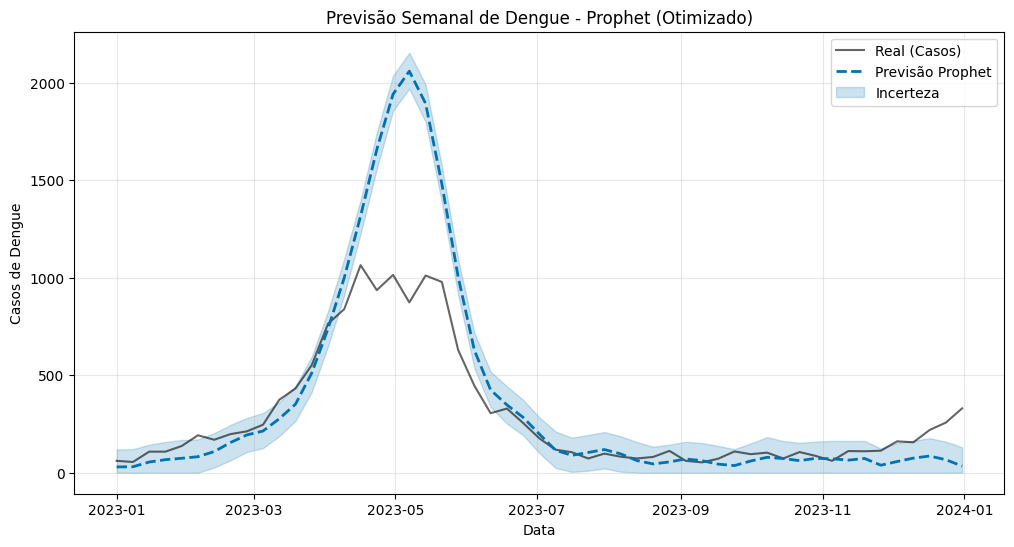

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

# --- 1. AGREGAÇÃO SEMANAL (Passo Fundamental) ---
# Garante que a data está no formato correto
df_sp['DT_NOTIFIC'] = pd.to_datetime(df_sp['DT_NOTIFIC'])

# Seleciona colunas numéricas e trata falhas
cols_numericas = ['casos_dengue', 'precipitacao', 'temperatura_maxima', 'temperatura_minima', 
                  'temperatura_ar', 'umidade_relativa', 'vento_velocidade']
# Filtra apenas as que existem
cols_existentes = [c for c in cols_numericas if c in df_sp.columns]

df_numeric = df_sp.set_index('DT_NOTIFIC')[cols_existentes].copy()
df_numeric = df_numeric.interpolate(method='linear').fillna(0)

# Regras: Soma para casos/chuva, Média para clima
agg_rules = {c: 'mean' for c in cols_existentes}
if 'casos_dengue' in agg_rules: agg_rules['casos_dengue'] = 'sum'
if 'precipitacao' in agg_rules: agg_rules['precipitacao'] = 'sum'

# Cria o dataframe semanal
df_semanal = df_numeric.resample('W').agg(agg_rules).reset_index()

# --- 2. FUNÇÃO PROPHET OTIMIZADA ---
def treinar_prophet_otimizado(df):
    print(">>> Treinando Prophet (Modo Multiplicativo)...")
    
    # Renomeia para o padrão do Prophet
    df_p = df.rename(columns={'DT_NOTIFIC': 'ds', 'casos_dengue': 'y'})
    
    # Divisão Treino/Teste
    split = int(len(df_p) * 0.75)
    train = df_p.iloc[:split]
    test = df_p.iloc[split:]
    
    # --- CORREÇÃO PRINCIPAL ---
    # seasonality_mode='multiplicative': Permite que os picos cresçam em anos epidêmicos
    m = Prophet(
        seasonality_mode='multiplicative', 
        weekly_seasonality=True, 
        yearly_seasonality=True,
        changepoint_prior_scale=0.05 # Aumente para 0.1 se o modelo estiver muito rígido
    )
    
    # Adiciona regressores climáticos se existirem
    for col in ['precipitacao', 'temperatura_ar', 'umidade_relativa']:
        if col in df_p.columns:
            m.add_regressor(col)
            
    m.fit(train)
    
    # Previsão
    forecast = m.predict(test.drop(columns=['y']))
    
    # Remove valores negativos para as métricas e gráfico
    y_true = test['y'].values
    y_pred = np.maximum(forecast['yhat'].values, 0)
    
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE Semanal: {mae:.2f}")
    
    # --- PLOT CUSTOMIZADO (Mais limpo que o m.plot) ---
    plt.figure(figsize=(12, 6))
    
    # Dados Reais
    plt.plot(test['ds'], y_true, label='Real (Casos)', color='black', alpha=0.6)
    
    # Previsão
    plt.plot(test['ds'], y_pred, label='Previsão Prophet', color='#0072B2', linestyle='--', linewidth=2)
    
    # Faixa de Incerteza (Clipada em 0 para não ficar estranha)
    y_lower = np.maximum(forecast['yhat_lower'].values, 0)
    y_upper = np.maximum(forecast['yhat_upper'].values, 0)
    plt.fill_between(test['ds'], y_lower, y_upper, color='#0072B2', alpha=0.2, label='Incerteza')
    
    plt.title("Previsão Semanal de Dengue - Prophet (Otimizado)")
    plt.xlabel("Data")
    plt.ylabel("Casos de Dengue")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return m

# Executa com os dados semanais
modelo_prophet = treinar_prophet_otimizado(df_semanal)